# 04 - EDA v3: Spectral Features (P1-P14)

Análise espectral via FFT + treino GNB com features combinadas (temporal + espectral).

- **Objetivo**: Melhorar separabilidade LOW vs MEDIUM
- **Pipeline**: 14 features espectrais (P1-P14) × 6 eixos = 84 features adicionais
- **Nota**: Com dados a 5Hz, Nyquist=2.5Hz (limitado). Retreinar com 20Hz para produção.

In [2]:
import numpy as np
import pandas as pd
import json
import os
import time
from scipy import stats as scipy_stats
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

SAMPLE_RATE = 20  # Hz (trocar para 20 com coleta 20Hz)
WINDOW_SIZE = 100
STEP_SIZE = 20

print(f'Sample rate: {SAMPLE_RATE} Hz, Nyquist: {SAMPLE_RATE/2} Hz')
print(f'Window: {WINDOW_SIZE} pts = {WINDOW_SIZE/SAMPLE_RATE:.1f}s')

Sample rate: 20 Hz, Nyquist: 10.0 Hz
Window: 100 pts = 5.0s


## 1. Funções: Features Temporais + Espectrais

In [3]:
def compute_spectral_features(signal, sample_rate):
    """Compute P1-P14 spectral features. Identical to JS implementation."""
    signal = np.asarray(signal, dtype=np.float64)
    N = int(2 ** np.ceil(np.log2(len(signal))))
    fft_vals = np.fft.rfft(signal, n=N)
    mag = np.abs(fft_vals) / N
    mag[1:-1] *= 2
    freq = np.fft.rfftfreq(N, d=1.0 / sample_rate)

    mag_ndc = mag[1:]
    freq_ndc = freq[1:]
    sumS = mag_ndc.sum()

    if sumS < 1e-15:
        return {f'P{i}': 0.0 for i in range(1, 15)}

    w = mag_ndc / sumS
    wf = np.sum(w * freq_ndc)
    wf2 = np.sum(w * freq_ndc**2)
    wf4 = np.sum(w * freq_ndc**4)

    P5 = wf
    P1 = P5
    P7 = np.sqrt(wf2)

    d = freq_ndc - P5
    var_ = np.sum(w * d**2)
    m3 = np.sum(w * d**3)
    m4 = np.sum(w * d**4)
    sqrtAbsDev = np.sum(w * np.sqrt(np.abs(d)))

    P2 = var_
    P6 = np.sqrt(P2)
    P14 = P6
    P3 = m3 / (P6**3) if P6 > 1e-15 else 0.0
    P4 = m4 / (P6**4) if P6 > 1e-15 else 0.0
    P8 = np.sqrt(np.sqrt(wf4 / wf2)) if wf2 > 1e-15 else 0.0
    P9 = wf2 / (P5**2) if P5 > 1e-15 else 0.0
    P10 = P6 / P5 if P5 > 1e-15 else 0.0
    P11 = P3
    P12 = P4
    P13 = sqrtAbsDev**2

    return {'P1': P1, 'P2': P2, 'P3': P3, 'P4': P4, 'P5': P5,
            'P6': P6, 'P7': P7, 'P8': P8, 'P9': P9, 'P10': P10,
            'P11': P11, 'P12': P12, 'P13': P13, 'P14': P14}


def axis_features(arr, prefix):
    """11 temporal features for one axis (aligned with JS)."""
    vals = np.asarray(arr, dtype=np.float64)
    n = len(vals)
    m = vals.mean()
    s = vals.std(ddof=0)
    rms = np.sqrt((vals**2).mean())
    abs_vals = np.abs(vals)
    abs_sorted = np.sort(abs_vals)
    peak = abs_sorted[int(0.95 * (n - 1))]
    mean_abs = abs_vals.mean()
    root_amp = (np.sqrt(abs_vals).mean())**2
    skew_val = scipy_stats.skew(vals, bias=True) if n >= 3 else 0.0
    kurt_val = scipy_stats.kurtosis(vals, fisher=True, bias=True) if n >= 4 else 0.0
    crest = peak / rms if rms > 1e-10 else 0.0
    shape = rms / mean_abs if mean_abs > 1e-10 else 0.0
    impulse = peak / mean_abs if mean_abs > 1e-10 else 0.0
    clearance = peak / root_amp if root_amp > 1e-10 else 0.0
    return {
        f'{prefix}_mean': m, f'{prefix}_std': s, f'{prefix}_skew': skew_val,
        f'{prefix}_kurtosis': kurt_val, f'{prefix}_rms': rms, f'{prefix}_peak': peak,
        f'{prefix}_root_amplitude': root_amp, f'{prefix}_crest_factor': crest,
        f'{prefix}_shape_factor': shape, f'{prefix}_impulse_factor': impulse,
        f'{prefix}_clearance_factor': clearance,
    }


AXES = ['accel_x_g', 'accel_y_g', 'accel_z_g', 'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']

def extract_all_features(window, sample_rate=SAMPLE_RATE):
    """Extract 66 temporal + 84 spectral = 150 features."""
    features = {}
    for ax in AXES:
        vals = window[ax].values
        features.update(axis_features(vals, ax))
        if sample_rate and sample_rate > 0:
            spec = compute_spectral_features(vals, sample_rate)
            for k, v in spec.items():
                features[f'{ax}_{k}'] = v
    return features

print(f'Features per window: 66 temporal + 84 spectral = 150')

Features per window: 66 temporal + 84 spectral = 150


## 2. Carga de Dados

In [50]:
# Tentar carregar do DB primeiro, fallback para CSV
try:
    from sqlalchemy import create_engine
    engine = create_engine('mysql+mysqlconnector://root:@localhost/iot_mpu6050')
    query = "SELECT * FROM sensor_data WHERE fan_state IN ('LOW','MEDIUM','HIGH') ORDER BY timestamp ASC"
    df_raw = pd.read_sql(query, engine)
    print(f'Dados do DB: {len(df_raw)} linhas')
except Exception as e:
    print(f'DB indisponível ({e}), carregando CSV...')
    csv_path = 'output/data/features_latest.csv'
    if not os.path.exists(csv_path):
        csv_path = 'output/data/raw_sensor_data_20260131_210511.csv'
    df_raw = pd.read_csv(csv_path)
    print(f'CSV carregado: {len(df_raw)} linhas')

print(f'Classes: {df_raw["fan_state"].value_counts().to_dict()}')

Dados do DB: 32100 linhas
Classes: {'HIGH': 10720, 'LOW': 10700, 'MEDIUM': 10680}


## 3. Feature Engineering (Temporal + Espectral)

In [51]:
X_list, y_list = [], []

for state in ['LOW', 'MEDIUM', 'HIGH']:
    df_state = df_raw[df_raw['fan_state'] == state].reset_index(drop=True)
    if len(df_state) < WINDOW_SIZE:
        print(f'{state}: insuficiente ({len(df_state)})')
        continue
    for i in range(WINDOW_SIZE, len(df_state), STEP_SIZE):
        w = df_state.iloc[i-WINDOW_SIZE:i]
        feats = extract_all_features(w, SAMPLE_RATE)
        X_list.append(feats)
        y_list.append(state)

X = pd.DataFrame(X_list)
y = np.array(y_list)

temporal_cols = [c for c in X.columns if '_P' not in c.split('_')[-1]]
spectral_cols = [c for c in X.columns if '_P' in c]

print(f'Dataset: {len(X)} amostras, {len(X.columns)} features')
print(f'  Temporais: {len(temporal_cols)}, Espectrais: {len(spectral_cols)}')
print(f'  Distribuição: {pd.Series(y).value_counts().to_dict()}')

Dataset: 1590 amostras, 150 features
  Temporais: 150, Espectrais: 84
  Distribuição: {'HIGH': 531, 'LOW': 530, 'MEDIUM': 529}


## 4. Visualização Espectral (FFT médio por classe)

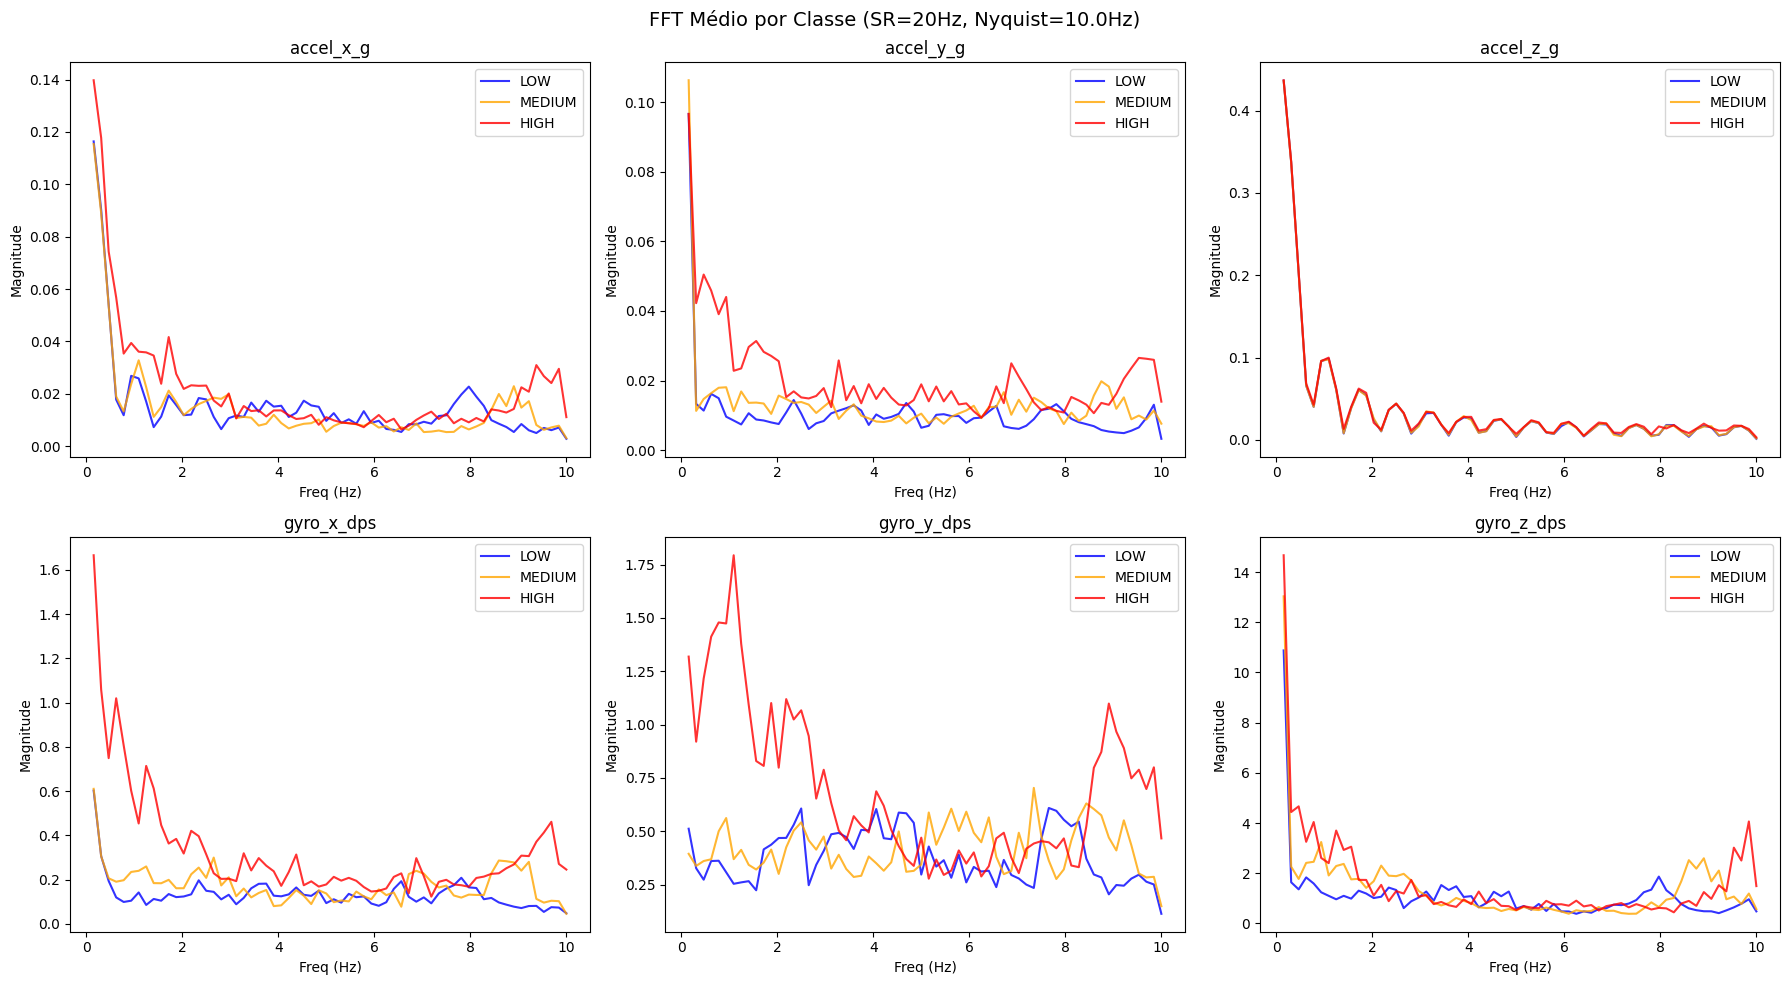

In [52]:
fig, axes_plot = plt.subplots(2, 3, figsize=(18, 10))
axes_plot = axes_plot.flatten()
colors = {'LOW': 'blue', 'MEDIUM': 'orange', 'HIGH': 'red'}

for idx, ax_name in enumerate(AXES):
    ax = axes_plot[idx]
    for state in ['LOW', 'MEDIUM', 'HIGH']:
        df_state = df_raw[df_raw['fan_state'] == state].reset_index(drop=True)
        if len(df_state) < WINDOW_SIZE:
            continue
        # Average FFT over windows
        all_mags = []
        for i in range(WINDOW_SIZE, min(len(df_state), WINDOW_SIZE + STEP_SIZE * 20), STEP_SIZE):
            sig = df_state[ax_name].iloc[i-WINDOW_SIZE:i].values
            N = int(2 ** np.ceil(np.log2(len(sig))))
            fft_v = np.fft.rfft(sig, n=N)
            mag = np.abs(fft_v) / N
            mag[1:-1] *= 2
            all_mags.append(mag)
        avg_mag = np.mean(all_mags, axis=0)
        freq = np.fft.rfftfreq(N, d=1.0/SAMPLE_RATE)
        ax.plot(freq[1:], avg_mag[1:], label=state, color=colors[state], alpha=0.8)
    ax.set_title(ax_name)
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Magnitude')
    ax.legend()

plt.suptitle(f'FFT Médio por Classe (SR={SAMPLE_RATE}Hz, Nyquist={SAMPLE_RATE/2}Hz)', fontsize=14)
plt.tight_layout()
plt.savefig('output/figures/04_fft_medio_por_classe.png', dpi=150)
plt.show()

## 5. ANOVA Ranking (150 features)

In [53]:
from scipy.stats import f_oneway

anova_results = []
for col in X.columns:
    groups = [X[col][y == c].values for c in ['LOW', 'MEDIUM', 'HIGH']]
    if all(len(g) > 1 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({'feature': col, 'f_statistic': f_stat, 'p_value': p_val,
                              'is_spectral': '_P' in col})

df_anova = pd.DataFrame(anova_results).sort_values('f_statistic', ascending=False)
df_sig = df_anova[df_anova['p_value'] < 0.05]

print(f'Features significativas (p<0.05): {len(df_sig)}/{len(df_anova)}')
print(f'  Temporais: {len(df_sig[~df_sig["is_spectral"]])}')
print(f'  Espectrais: {len(df_sig[df_sig["is_spectral"]])}')
print(f'\nTop 20 features:')
df_sig.head(20)[['feature', 'f_statistic', 'p_value', 'is_spectral']]

Features significativas (p<0.05): 144/150
  Temporais: 62
  Espectrais: 82

Top 20 features:


,feature,f_statistic,p_value,is_spectral
51,accel_z_g_std,29261.235377,0.0,False
58,accel_z_g_shape_factor,18137.879487,0.0,False
60,accel_z_g_clearance_factor,11050.865376,0.0,False
59,accel_z_g_impulse_factor,10883.830019,0.0,False
57,accel_z_g_crest_factor,10553.087838,0.0,False
1,accel_x_g_std,6712.065048,0.0,False
76,gyro_x_dps_std,6485.447415,0.0,False
80,gyro_x_dps_peak,6425.134678,0.0,False
55,accel_z_g_peak,6248.930670,0.0,False
101,gyro_y_dps_std,5998.134724,0.0,False


## 6. Separabilidade LOW vs MEDIUM (SNR por feature)

In [54]:
snr_results = []
for col in X.columns:
    low = X[col][y == 'LOW']
    med = X[col][y == 'MEDIUM']
    mean_diff = abs(low.mean() - med.mean())
    pooled_std = np.sqrt((low.std()**2 + med.std()**2) / 2)
    snr = mean_diff / pooled_std if pooled_std > 1e-10 else 0
    snr_results.append({'feature': col, 'snr_low_med': snr, 'is_spectral': '_P' in col})

df_snr = pd.DataFrame(snr_results).sort_values('snr_low_med', ascending=False)
print('Top 20 features para separar LOW vs MEDIUM (SNR):')
df_snr.head(20)

Top 20 features para separar LOW vs MEDIUM (SNR):


,feature,snr_low_med,is_spectral
130,gyro_z_dps_peak,6.394089,False
76,gyro_x_dps_std,4.493798,False
102,gyro_y_dps_skew,3.490123,False
108,gyro_y_dps_shape_factor,3.341477,False
110,gyro_y_dps_clearance_factor,2.829078,False
109,gyro_y_dps_impulse_factor,2.754850,False
129,gyro_z_dps_rms,2.643105,False
103,gyro_y_dps_kurtosis,2.639117,False
105,gyro_y_dps_peak,2.577534,False
18,accel_x_g_P8,2.345073,True


## 7. Seleção de Features (Conjuntos D, E, F)

In [55]:
# Significativas com p < 0.05
sig_features = set(df_sig['feature'].values)

# Remove highly correlated (>0.85) - keep higher ANOVA
def remove_correlated(feature_list, X_data, threshold=0.85):
    corr = X_data[feature_list].corr().abs()
    anova_rank = {f: i for i, f in enumerate(df_anova['feature'].values)}
    to_drop = set()
    for i in range(len(feature_list)):
        for j in range(i+1, len(feature_list)):
            if corr.iloc[i, j] > threshold:
                fi, fj = feature_list[i], feature_list[j]
                # Drop the one with lower ANOVA rank
                drop = fj if anova_rank.get(fi, 999) < anova_rank.get(fj, 999) else fi
                to_drop.add(drop)
    return [f for f in feature_list if f not in to_drop]

# D: Temporal top (baseline)
temporal_sig = [f for f in df_anova['feature'].values if f in sig_features and '_P' not in f]
set_D = remove_correlated(temporal_sig[:20], X)

# E: Spectral top
spectral_sig = [f for f in df_anova['feature'].values if f in sig_features and '_P' in f]
set_E = remove_correlated(spectral_sig[:20], X)

# F: Combined best
combined_sig = [f for f in df_anova['feature'].values if f in sig_features][:30]
set_F = remove_correlated(combined_sig, X)

print(f'Set D (temporal): {len(set_D)} features')
print(f'Set E (spectral): {len(set_E)} features')
print(f'Set F (combined): {len(set_F)} features')
print(f'\nSet F: {set_F}')

Set D (temporal): 1 features
Set E (spectral): 7 features
Set F (combined): 4 features

Set F: ['accel_z_g_std', 'accel_x_g_P8', 'gyro_y_dps_P14', 'gyro_x_dps_P8']


## 8. Treino GNB: Comparar D / E / F (CV 5-fold)

In [56]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, feature_set in [('D (temporal)', set_D), ('E (spectral)', set_E), ('F (combined)', set_F)]:
    if not feature_set:
        print(f'{name}: sem features significativas')
        continue
    clf = GaussianNB()
    scores = cross_val_score(clf, X[feature_set], y, cv=cv, scoring='accuracy')
    results[name] = scores
    print(f'{name}: {scores.mean()*100:.2f}% ± {scores.std()*100:.2f}% ({len(feature_set)} features)')

# Select best set
best_name = max(results, key=lambda k: results[k].mean())
best_features = {'D (temporal)': set_D, 'E (spectral)': set_E, 'F (combined)': set_F}[best_name]
print(f'\nMelhor: {best_name}')

D (temporal): 88.68% ± 1.03% (1 features)
E (spectral): 93.71% ± 1.11% (7 features)
F (combined): 96.16% ± 0.81% (4 features)

Melhor: F (combined)


## 9. Confusion Matrix

              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00       531
         LOW       0.93      0.95      0.94       530
      MEDIUM       0.95      0.93      0.94       529

    accuracy                           0.96      1590
   macro avg       0.96      0.96      0.96      1590
weighted avg       0.96      0.96      0.96      1590



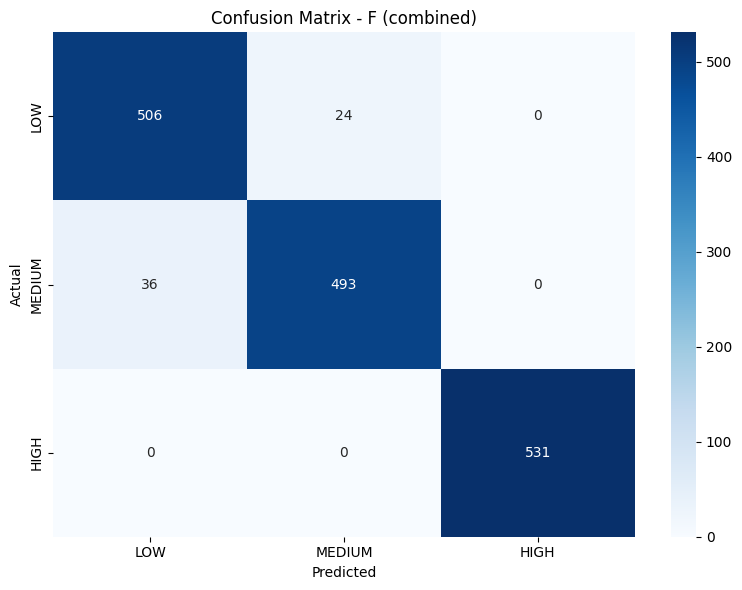

In [57]:
clf_final = GaussianNB()
clf_final.fit(X[best_features], y)
y_pred = clf_final.predict(X[best_features])

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=['LOW', 'MEDIUM', 'HIGH'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW', 'MEDIUM', 'HIGH'],
            yticklabels=['LOW', 'MEDIUM', 'HIGH'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.savefig('output/figures/04_confusion_matrix_spectral.png', dpi=150)
plt.show()

## 10. Simulação de Transição (Simetria H→L vs L→H)

In [58]:
# Simular transição: construir janelas que cruzam fronteira entre estados
transitions = [('LOW', 'HIGH'), ('HIGH', 'LOW'), ('LOW', 'MEDIUM'), ('MEDIUM', 'LOW')]

for from_state, to_state in transitions:
    df_from = df_raw[df_raw['fan_state'] == from_state].tail(WINDOW_SIZE // 2)
    df_to = df_raw[df_raw['fan_state'] == to_state].head(WINDOW_SIZE // 2)
    if len(df_from) < WINDOW_SIZE // 2 or len(df_to) < WINDOW_SIZE // 2:
        print(f'{from_state}→{to_state}: dados insuficientes')
        continue
    mixed = pd.concat([df_from, df_to]).reset_index(drop=True)
    feats = extract_all_features(mixed, SAMPLE_RATE)
    feats_s = pd.DataFrame([feats])
    pred = clf_final.predict(feats_s[best_features])
    proba = clf_final.predict_proba(feats_s[best_features])
    print(f'{from_state}→{to_state}: pred={pred[0]}, proba={dict(zip(clf_final.classes_, proba[0].round(3)))}')

LOW→HIGH: pred=HIGH, proba={'HIGH': 1.0, 'LOW': 0.0, 'MEDIUM': 0.0}
HIGH→LOW: pred=HIGH, proba={'HIGH': 1.0, 'LOW': 0.0, 'MEDIUM': 0.0}
LOW→MEDIUM: pred=MEDIUM, proba={'HIGH': 0.0, 'LOW': 0.003, 'MEDIUM': 0.997}
MEDIUM→LOW: pred=LOW, proba={'HIGH': 0.0, 'LOW': 0.974, 'MEDIUM': 0.026}


## 11. Exportação: Modelo JSON + feature_config.json

In [59]:
# Export model JSON
train_acc = accuracy_score(y, y_pred)
cv_scores = cross_val_score(clf_final, X[best_features], y, cv=5)

model_data = {
    'type': 'gaussian_nb',
    'version': '5.0_spectral',
    'generated_at': time.strftime('%Y-%m-%d %H:%M:%S'),
    'sample_rate_hz': SAMPLE_RATE,
    'features': list(best_features),
    'labels': list(clf_final.classes_),
    'priors': {label: float(clf_final.class_prior_[i]) for i, label in enumerate(clf_final.classes_)},
    'stats': {},
    'metrics': {
        'train_accuracy': float(train_acc),
        'cv_accuracy_mean': float(cv_scores.mean()),
        'cv_accuracy_std': float(cv_scores.std()),
    },
    'training_info': {
        'total_samples': int(len(X)),
        'window_size': WINDOW_SIZE,
        'step_size': STEP_SIZE,
        'feature_set': best_name,
        'n_temporal': len([f for f in best_features if '_P' not in f]),
        'n_spectral': len([f for f in best_features if '_P' in f]),
    }
}

for i, label in enumerate(clf_final.classes_):
    model_data['stats'][label] = {}
    for j, feat in enumerate(best_features):
        model_data['stats'][label][feat] = {
            'mean': float(clf_final.theta_[i, j]),
            'var': float(clf_final.var_[i, j])
        }

timestamp = time.strftime('%Y%m%d')
model_path = f'output/models/gnb_model_spectral_{timestamp}.json'
os.makedirs('output/models', exist_ok=True)
with open(model_path, 'w') as f:
    json.dump(model_data, f, indent=2)

# Also save to project models/
model_path2 = f'../models/gnb_model_spectral_{timestamp}.json'
with open(model_path2, 'w') as f:
    json.dump(model_data, f, indent=2)

print(f'Modelo exportado: {model_path}')
print(f'Modelo exportado: {model_path2}')
print(f'Features: {len(best_features)} ({best_name})')
print(f'Acurácia CV: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%')

# Update feature_config.json
config_path = '../config/feature_config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

config['version'] = '5.0'
config['selected_features'] = list(best_features)
config['feature_count'] = len(best_features)
config['generated_at'] = time.strftime('%Y%m%d_%H%M%S')

with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f'Config atualizado: {config_path}')

Modelo exportado: output/models/gnb_model_spectral_20260201.json
Modelo exportado: ../models/gnb_model_spectral_20260201.json
Features: 4 (F (combined))
Acurácia CV: 96.23% ± 2.65%
Config atualizado: ../config/feature_config.json
